# Imports

In [1]:
from keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
import tensorflow as tf
from keras.metrics import Precision, Recall
from IPython.display import clear_output
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow_examples.models.pix2pix import pix2pix 
from keras.models import Model, load_model  # Import Sequential and Model for defining neural network models
import numpy as np
from keras.utils import array_to_img
import tensorflow.keras.backend as K
from keras.saving import register_keras_serializable
from PIL import Image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Concatenate, Conv2DTranspose, Dense, GlobalAveragePooling2D, BatchNormalization, MaxPooling2D, Dropout, UpSampling2D, Conv2D, Reshape, Normalization # Import various layers from Keras
import warnings  # Import warnings module
import os  # Import os module
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')  # Ignore warnings
from keras.saving import register_keras_serializable
import matplotlib.pyplot as plt  # Import matplotlib for plotting

In [2]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(array_to_img(display_list[i]), cmap='gray')
    plt.axis('off')
  plt.show()

In [3]:
# Directory paths
train_img_dir = 'Image/Train-images'
train_mask_dir = 'Mask/Train-Masks'
test_img_dir = 'Image/Test-images'
test_mask_dir = 'Mask/Test-Masks'

In [4]:
# Function to load and resize images from directory
def load_images_from_directory(directory, fixed_size):
    images = []
    for filename in sorted(os.listdir(directory), key=lambda x: int(x.split('.')[0])):
        img_path = os.path.join(directory, filename)
        image = Image.open(img_path).resize(fixed_size)  # Resize images to fixed size
        image = image.convert("RGB")  # Convert image to RGB format
        image = np.array(image)
        images.append(image)
    return np.array(images)

In [5]:
# Load and resize test images
fixed_size = (224, 224)
input_shape = [224,224,3]

In [6]:
test_images = load_images_from_directory(test_img_dir, fixed_size)
train_images_loaded = load_images_from_directory(train_img_dir, fixed_size)
test_masks_loaded = load_images_from_directory(test_mask_dir, fixed_size)
train_masks_loaded = load_images_from_directory(train_mask_dir, fixed_size)

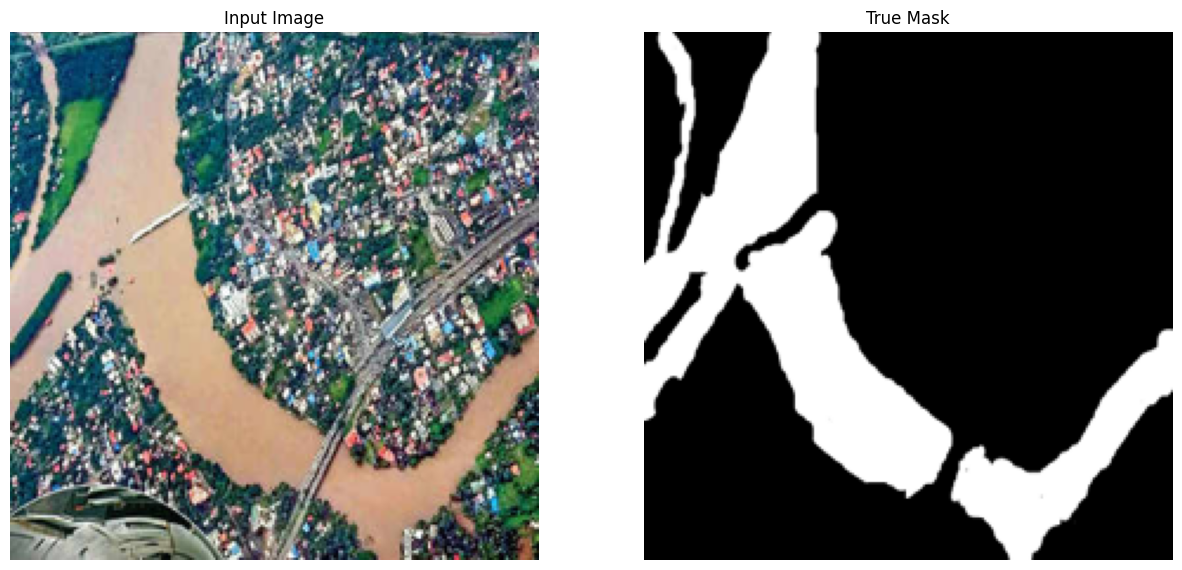

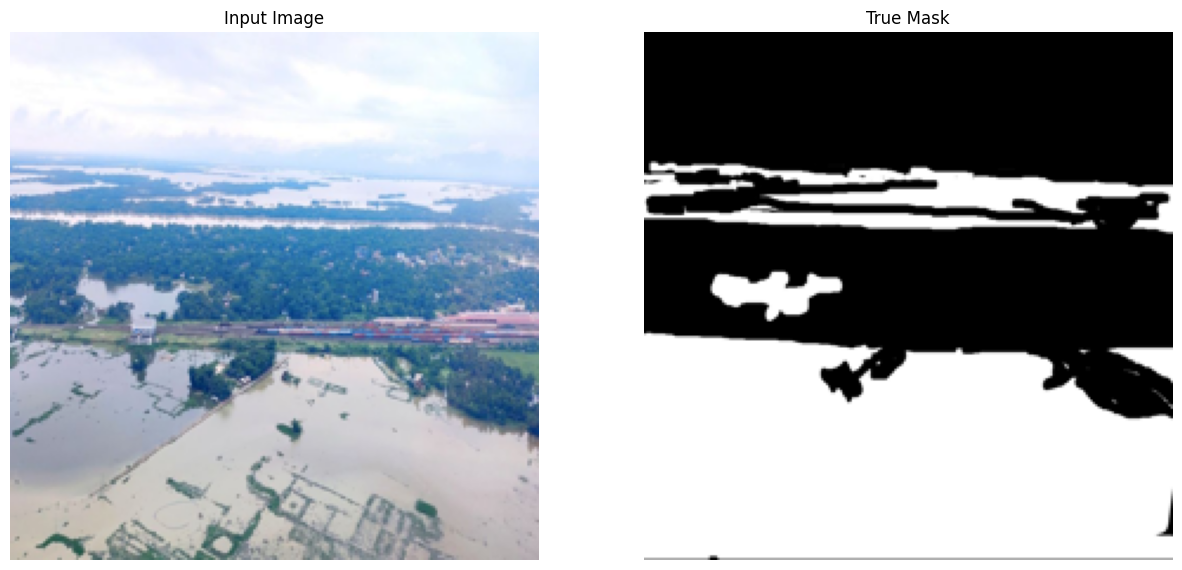

In [7]:
i = 15
for sample_image, sample_mask in zip(train_images_loaded[i:i+2], train_masks_loaded[i:i+2]):
    display([sample_image, sample_mask])

In [8]:
train_masks_binary = np.where(train_masks_loaded == 0, 0.0, 1.0)
test_masks_binary = np.where(test_masks_loaded == 0, 0.0, 1.0)

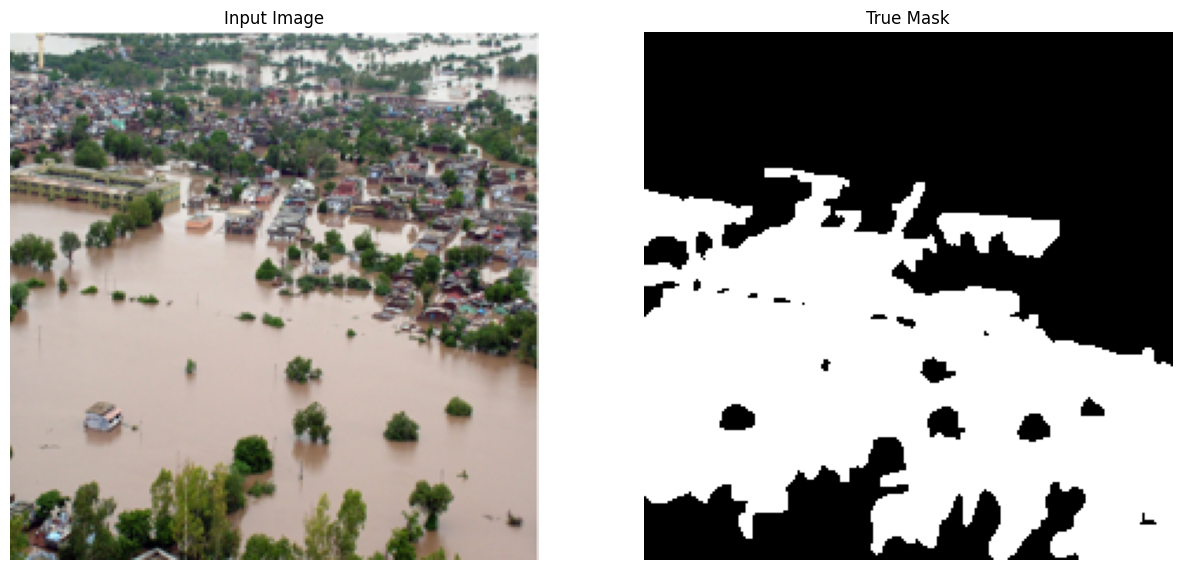

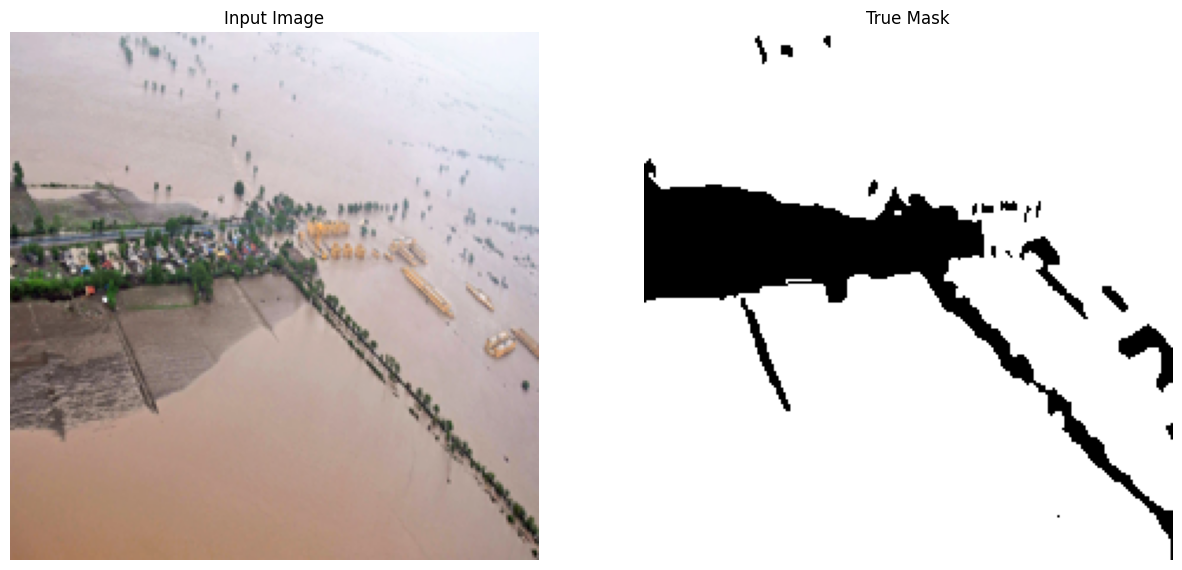

In [9]:
i = 12
for sample_image, sample_mask in zip(test_images[i:i+2], test_masks_binary[i:i+2]):
    display([sample_image, sample_mask])

In [10]:
# Function to convert RGB mask to binary mask
def rgb_to_binary(mask):
    # Convert RGB to grayscale
    grayscale_mask = tf.image.rgb_to_grayscale(mask)
    # Threshold the grayscale image
    binary_mask = tf.where(grayscale_mask > 0.5, 1.0, 0.0)
    return binary_mask.numpy()

In [11]:
train_masks = (rgb_to_binary(train_masks_binary))
test_masks = (rgb_to_binary(test_masks_binary))

In [12]:
# Splitting the test set into validation and remaining test sets
train_images, valid_images, train_masks, valid_masks = train_test_split(train_images_loaded, train_masks, test_size=0.15, random_state=42)

In [13]:
# Print the shapes of the created sets
print("Train Images Shape:", train_images.shape)
print("Test Images Shape:", test_images.shape)
print("Valid Images Shape:", valid_images.shape)
print("Train Masks Shape:", train_masks.shape)
print("Test Masks Shape:", test_masks.shape)
print("Valid Masks Shape:", valid_masks.shape)

Train Images Shape: (157, 224, 224, 3)
Test Images Shape: (105, 224, 224, 3)
Valid Images Shape: (28, 224, 224, 3)
Train Masks Shape: (157, 224, 224, 1)
Test Masks Shape: (105, 224, 224, 1)
Valid Masks Shape: (28, 224, 224, 1)


In [14]:
base_model = MobileNetV2(input_shape=input_shape, include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

In [15]:
# Create the feature extraction model
down_stack = Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

In [16]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [17]:
def unet_model(output_channels:int):
  inputs = Input(shape=input_shape)

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)
 
  return Model(inputs=inputs, outputs=x)

In [18]:
OUTPUT_CLASSES = 1
model = unet_model(output_channels=OUTPUT_CLASSES)

In [19]:
p = Precision()
r = Recall()

In [20]:
model.compile(optimizer='adam',
              loss=BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', p, r])

In [21]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ [(None, 112, 112, │  1,841,984 │ input_layer_1[0]… │
│ (Functional)        │ 96), (None, 56,   │            │                   │
│                     │ 56, 144), (None,  │            │                   │
│                     │ 28, 28, 192),     │            │                   │
│                     │ (None, 14, 14,    │            │                   │
│                     │ 576), (None, 7,   │            │                   │
│                     │ 7, 320)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 14, 14,    │  1,476,608 │ functional_1[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 14, 14,    │          0 │ sequential[0][0], │
│ (Concatenate)       │ 1088)             │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 28, 28,    │  2,507,776 │ concatenate[0][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 28, 28,    │          0 │ sequential_1[0][… │
│ (Concatenate)       │ 448)              │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 56, 56,    │    516,608 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 56, 56,    │          0 │ sequential_2[0][… │
│ (Concatenate)       │ 272)              │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 112, 112,  │    156,928 │ concatenate_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 112, 112,  │          0 │ sequential_3[0][… │
│ (Concatenate)       │ 160)              │            │ functional_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 224, 224,  │      1,441 │ concatenate_3[0]… │
│ (Conv2DTranspose)   │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,501,345 (24.80 MB)

 Trainable params: 4,657,441 (17.77 MB)

 Non-trainable params: 1,843,904 (7.03 MB)

In [38]:
import random

def show_predictions(model, train_images=None, train_masks=None, num=1):
    if not(train_images is None or train_masks is None):
        indices = random.sample(range(len(train_images)), num)
        for i in indices:
            image = train_images[i][tf.newaxis, ...]
            mask = train_masks[i][tf.newaxis, ...]
            pred_mask = model.predict(image).reshape((224,224,1))
            clean_pred_mask = np.where(pred_mask>0.5,1.0,0.0)
            display([train_images[i], train_masks[i], clean_pred_mask])
    else:
        display([sample_image, sample_mask, np.where(model.predict(sample_image[tf.newaxis, ...]).reshape((224,224,1))>0.5,1.0,0.0)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


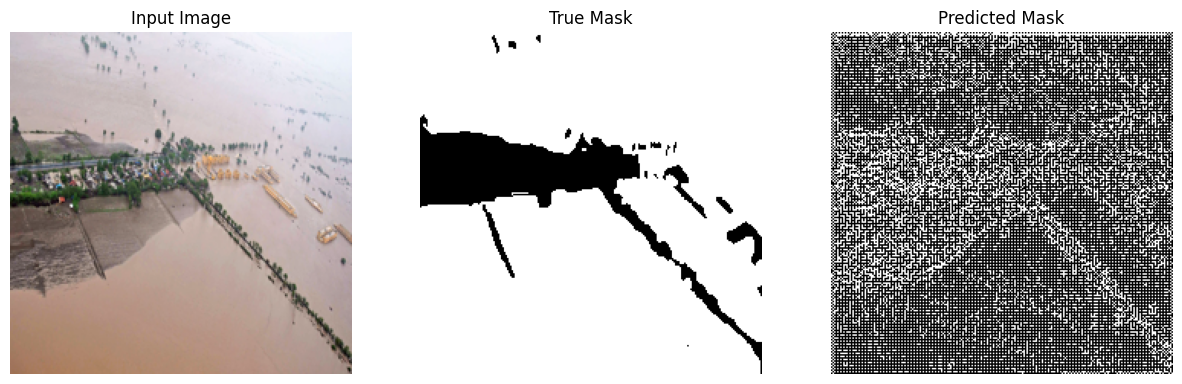

In [23]:
show_predictions()

In [24]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
    
display_callback = DisplayCallback()

In [25]:
BATCH_SIZE = 8
n_epochs = 1000

In [26]:
save_name = 'Mobile_Encoder_pix2pix_Decoder'

In [27]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath=f'models/{save_name}.keras',
                                  save_best_only=True,
                                  verbose=1)

In [28]:
# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=30,
                           restore_best_weights=True,
                           mode='min')

In [29]:
history = model.fit(train_images, train_masks,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=[valid_images, valid_masks],
                            callbacks=[tl_checkpoint_1],
                            verbose=1)

Epoch 1/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.5870 - loss: 0.7695 - precision: 0.5589 - recall: 0.3214
Epoch 1: val_loss improved from inf to 0.65532, saving model to models/Mobile_Encoder_pix2pix_Decoder.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 468ms/step - accuracy: 0.5903 - loss: 0.7632 - precision: 0.5655 - recall: 0.3227 - val_accuracy: 0.7267 - val_loss: 0.6553 - val_precision: 0.6455 - val_recall: 0.8708
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.7942 - loss: 0.4549 - precision: 0.8563 - recall: 0.6101
Epoch 2: val_loss did not improve from 0.65532
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step - accuracy: 0.7940 - loss: 0.4551 - precision: 0.8565 - recall: 0.6100 - val_accuracy: 0.6224 - val_loss: 1.1447 - val_precision: 0.5456 - val_recall: 0.9602
Epoch 3/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8047 - loss: 0.4356 - precision: 0.8676 - recall: 0.6482
Epoch 3: val_loss improved from 0.65532 to 0.62478, saving model to mod

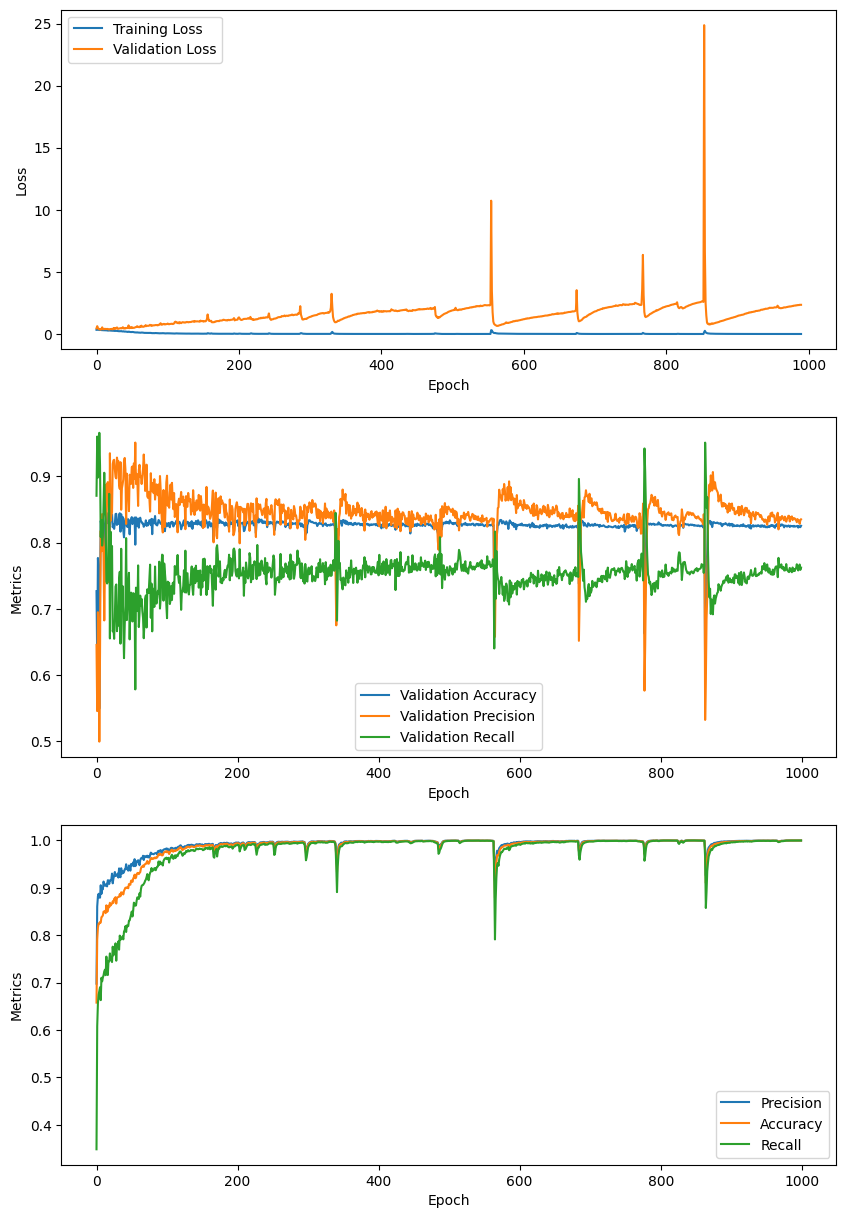

In [40]:
import matplotlib.pyplot as plt

# Plotting training loss and validation loss
plt.figure(figsize=(10, 15))

# Subplot 1: Training Loss and Validation Loss
plt.subplot(3, 1, 1)
plt.plot(history.history['loss'][10:], label='Training Loss')
plt.plot(history.history['val_loss'][10:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Subplot 2: Validation Metrics (accuracy, precision, recall)
plt.subplot(3, 1, 2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

# Subplot 3: Precision, Accuracy, Recall
plt.subplot(3, 1, 3)
plt.plot(history.history['precision'], label='Precision')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['recall'], label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

# Saving the plot
plt.savefig(f'graphs/{save_name.split(".")[0]}.png')

# Show the plot
plt.show()


In [33]:
best_model = load_model(f"models/{save_name}.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


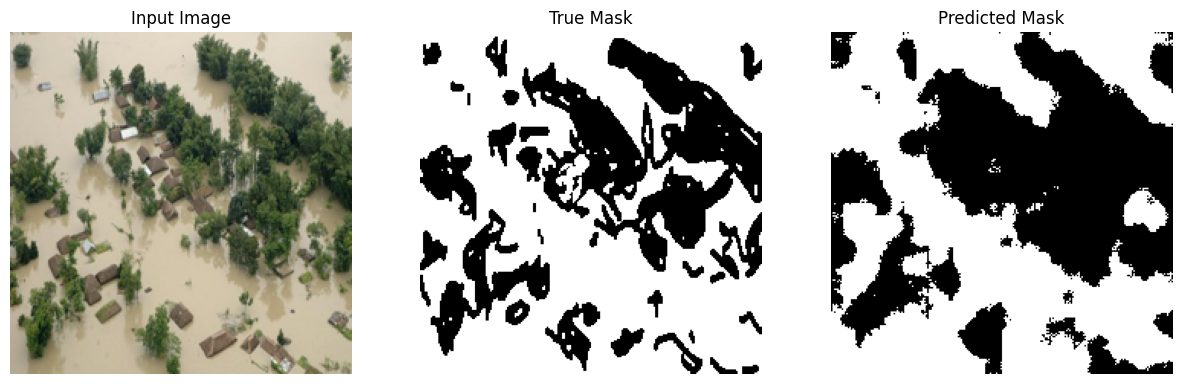

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


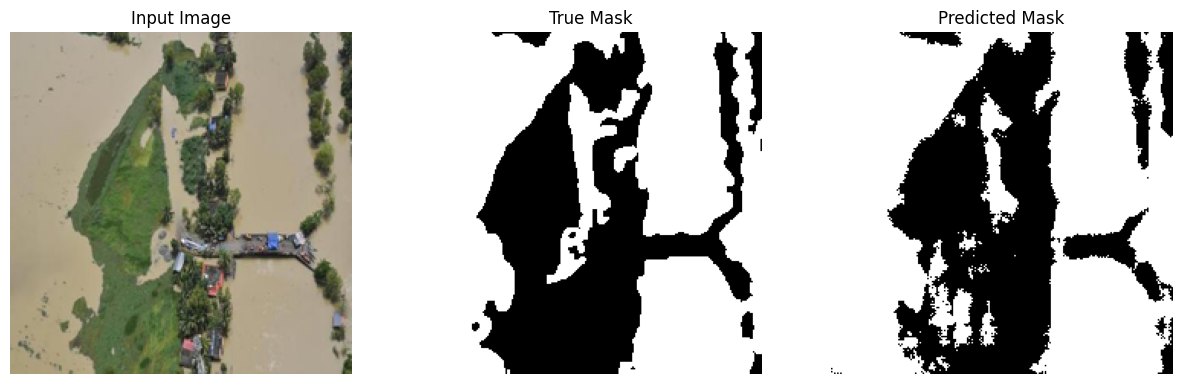

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


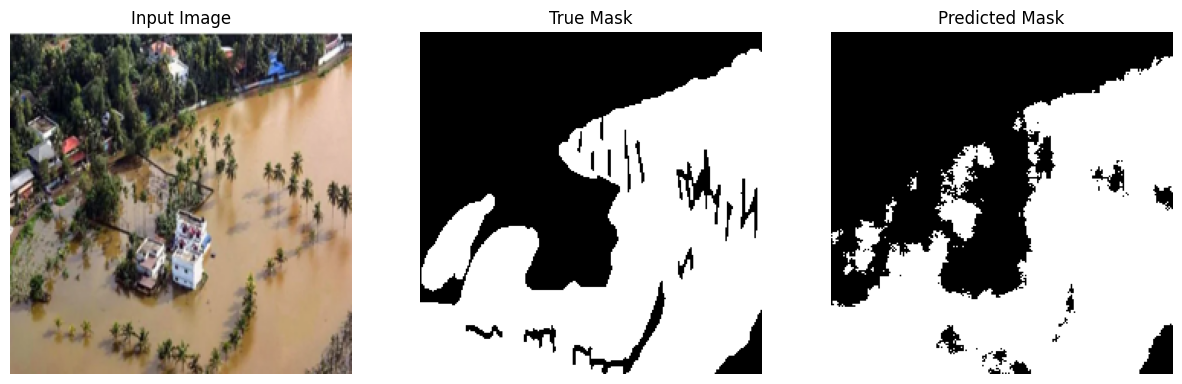

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


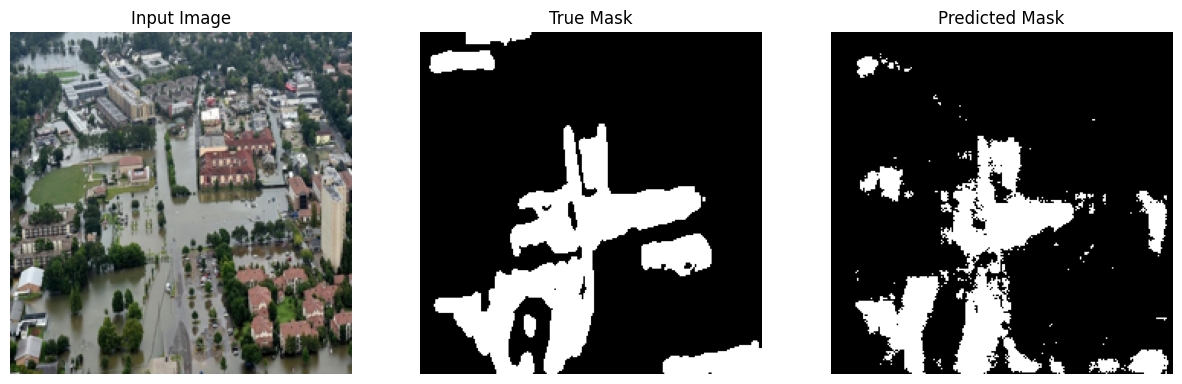

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


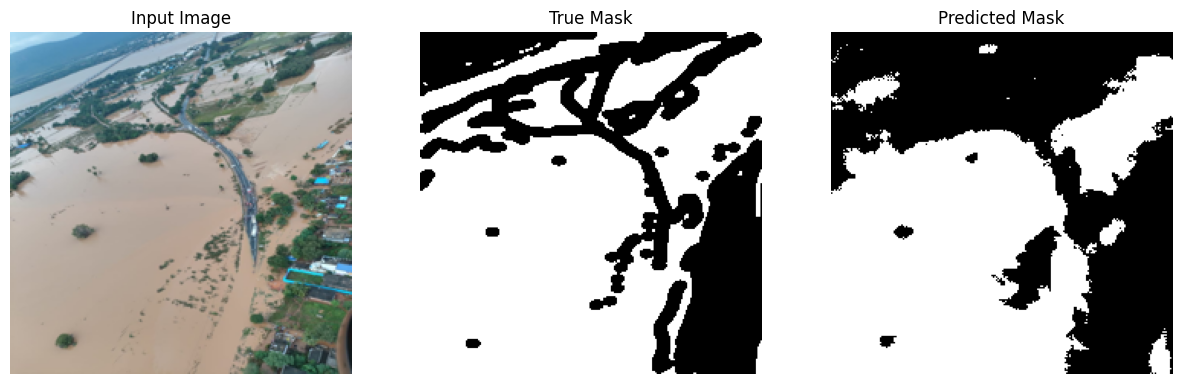

In [39]:
show_predictions(best_model, test_images, test_masks, num=5)